### Imports

In [18]:
# Data Management
import numpy as np
import pandas as pd

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Deep Learning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction and Feature Engineering

In [2]:
# Load data from saved file
df = pd.read_csv("data/pair_trade.csv")
df.drop(columns="Date", inplace=True)
df["lrets_a1"] = np.log(df["Asset1"] / df["Asset1"].shift(1))
df["lrets_a2"] = np.log(df["Asset2"] / df["Asset2"].shift(1))
df["lrets_a1_roll"] = df["lrets_a1"].rolling(window=21).mean()
df["lrets_a2_roll"] = df["lrets_a2"].rolling(window=21).mean()
df["a1_prod_rets"] = df["lrets_a1"].cumsum()
df["a2_prod_rets"] = df["lrets_a2"].cumsum()
df.dropna(inplace=True)
print("Length: ", len(df))
df.head(2)

Length:  1243


,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998


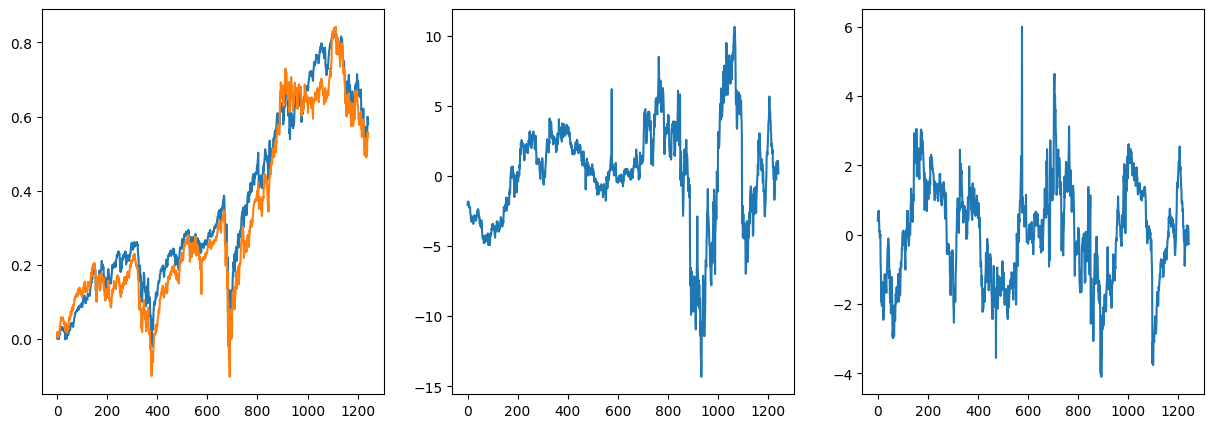

In [8]:
# Visualize Data
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(df["a1_prod_rets"].values)
plt.plot(df["a2_prod_rets"].values)

plt.subplot(1, 3, 2)
plt.plot(df["Spread"].values)

plt.subplot(1, 3, 3)
plt.plot(df["ZScore"].values)

In [19]:
# Add Target
future_step = 1
df["TARGET"] = 0
df.loc[df["Spread"].shift(-future_step) > 0, "TARGET"] = 1
df.dropna(inplace=True)
df.head(2)

,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,TARGET
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551,0
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998,0


In [30]:
df

,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,TARGET
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551,0
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998,0
23,54.256935,53.133030,-1.879984,0.634294,0.012379,0.011956,0.000640,0.000793,0.011617,0.014954,0
24,53.658115,52.521286,-1.832474,0.689018,-0.011098,-0.011580,0.000077,0.000134,0.000519,0.003374,0
25,53.932976,52.767960,-1.818233,0.694927,0.005109,0.004686,-0.000113,-0.000080,0.005628,0.008059,0
...,...,...,...,...,...,...,...,...,...,...,...
1259,92.930000,86.949997,1.064264,0.255584,0.012343,0.010753,-0.002281,-0.001774,0.549732,0.507488,1
1260,95.080002,89.040001,1.006103,0.216648,0.022872,0.023753,-0.001353,-0.001058,0.572605,0.531241,1
1261,97.660004,91.400002,1.092681,0.238969,0.026773,0.026160,-0.000994,-0.000631,0.599378,0.557401,1
1262,96.480003,90.540001,0.821301,0.083033,-0.012156,-0.009454,0.000143,0.000063,0.587222,0.547947,1


In [35]:
# Split X and y
X_data = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
len(X_data), len(y)

(1243, 1243)

In [23]:
# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_data)
X[:2]

array([[-1.26492611, -1.13504476, -0.63395987,  0.25890302, -0.06874343,
         0.0197518 ,  0.02761802,  0.13117419, -1.46674999, -1.28742802],
       [-1.29718371, -1.17576153, -0.58682679,  0.42967168, -0.84531675,
        -0.94004753, -0.15727973, -0.06985924, -1.51634206, -1.34812881]])

### Dataload Structuring

In [24]:
# Dataset Class
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.length = self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(X, y)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

In [25]:
#Review X Data
trainloader.dataset.X[:2]

tensor([[-1.2649, -1.1350, -0.6340,  0.2589, -0.0687,  0.0198,  0.0276,  0.1312,
         -1.4668, -1.2874],
        [-1.2972, -1.1758, -0.5868,  0.4297, -0.8453, -0.9400, -0.1573, -0.0699,
         -1.5163, -1.3481]])

In [31]:
# Review y Data
trainloader.dataset.y[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Build Neural Net

In [36]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()   
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Train Neural Net

In [37]:
# Hyperparams
learning_rate = 0.01
epochs = 1000

# Model, Optimizer, Loss
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

In [38]:
# Forward Loop
losses = []
accur = []
for i in range(epochs):
    for j, (X_train, y_train) in enumerate(trainloader):
        
        # Calculate ouput
        output = model(X_train)
        
        # Calculate loss
        loss = loss_fn(output, y_train.reshape(-1, 1))
        
        # Calculate accuracy
        predicted = model(torch.tensor(X, dtype=torch.float32))
        acc = (predicted.detach().numpy().round() == y).mean()
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print Results
        if i % 100 == 0:
            losses.append(loss)
            accur.append(acc)
            print(f"Epoch: {i}, Loss: {loss}, Accuracy: {acc}")

Epoch: 0, Loss: 0.7180806398391724, Accuracy: 0.5256092201606551
Epoch: 0, Loss: 0.5787729620933533, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 0.5739769339561462, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 0.9536672830581665, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 0.9271665811538696, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 1.1455518007278442, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 0.9222590923309326, Accuracy: 0.40176525145804437
Epoch: 0, Loss: 0.8700700998306274, Accuracy: 0.4089009474780412
Epoch: 0, Loss: 0.5749866962432861, Accuracy: 0.4238066236087011
Epoch: 0, Loss: 0.6883172392845154, Accuracy: 0.4434694304193589
Epoch: 0, Loss: 0.713471531867981, Accuracy: 0.46344937927534985
Epoch: 0, Loss: 0.4999430775642395, Accuracy: 0.4867593196073393
Epoch: 0, Loss: 0.5931240320205688, Accuracy: 0.5141921065286602
Epoch: 0, Loss: 0.6033432483673096, Accuracy: 0.542100606517981
Epoch: 0, Loss: 0.6839455962181091, Accuracy: 0.5614462712833056
Epoch: 0, Loss: 0.6093246

Epoch: 700, Loss: 9.639128384364426e-11, Accuracy: 0.5194249502766579
Epoch: 700, Loss: 1.2101194827374476e-19, Accuracy: 0.5195835212993245
Epoch: 700, Loss: 0.05809450149536133, Accuracy: 0.5195835212993245
Epoch: 700, Loss: 0.06320164352655411, Accuracy: 0.5195835212993245
Epoch: 700, Loss: 0.012864060699939728, Accuracy: 0.5195835212993245
Epoch: 700, Loss: 0.0, Accuracy: 0.5194249502766579
Epoch: 700, Loss: 1.844024808406175e-07, Accuracy: 0.5194249502766579
Epoch: 700, Loss: 0.020398875698447227, Accuracy: 0.5194249502766579
Epoch: 700, Loss: 0.07950404286384583, Accuracy: 0.5194249502766579
Epoch: 700, Loss: 0.029320430010557175, Accuracy: 0.5191078082313247
Epoch: 700, Loss: 0.11600317806005478, Accuracy: 0.5191078082313247
Epoch: 700, Loss: 1.2517239156295545e-06, Accuracy: 0.5189492372086582
Epoch: 700, Loss: 6.463474164775107e-07, Accuracy: 0.5189492372086582
Epoch: 700, Loss: 0.007771580945700407, Accuracy: 0.5187906661859916
Epoch: 700, Loss: 0.00012777063238900155, Accura